In [2]:
#We will make a basic CNN model to classify CIFAR-10#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

#show the tensorflow version
print(tf.__version__)

2.15.0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5618395665050473261
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1264261160549370090
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

170498071/170498071 [==============================] - 14s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
import copy
x_train_copy = copy.deepcopy(x_train)

## Cutout Regularization

In [6]:
def apply_cutout(image, n_holes=1, length=14):
    h = image.shape[0] # height
    w = image.shape[1] # width

    mask = np.ones((h, w, 3), np.float32) # Create a mask to be applied to the regions that are cutout

    for _ in range(n_holes): # Number of regions to be cutout. Vary to check performance.
        y = np.random.randint(h) # Get a y coordinate in the image
        x = np.random.randint(w) # Get an x coordinate in the image

        y1 = np.clip(y - length // 2, 0, h) # top edge of the cutout region
        y2 = np.clip(y + length // 2, 0, h) # bottom edge of the cutout region
        x1 = np.clip(x - length // 2, 0, w) # left edge of the cutout region
        x2 = np.clip(x + length // 2, 0, w) # right edge of the cutout region

        mask[y1: y2, x1: x2, :] = 0 # Apply the mask (introduce black or 0 regions in the image)

    return image * mask # Return the image with the mask applied

In [7]:
x_train_cutout = np.array([apply_cutout(image) for image in x_train])

Original images:


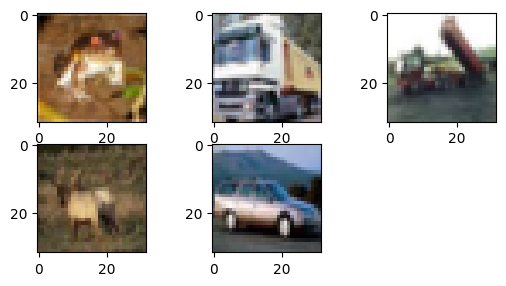

Images with cutout:


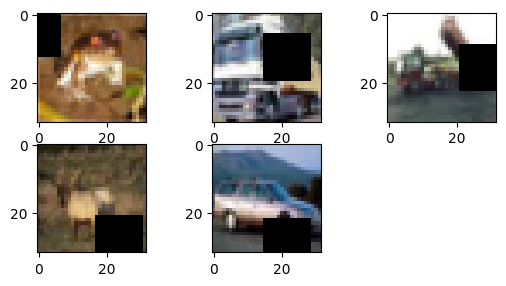

In [8]:
import matplotlib.pyplot as plt
print("Original images:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()
print("Images with cutout:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(apply_cutout(x_train[i]))
plt.show()

## Random Erasing Regularization

In [9]:
def random_erasing(image, probability=0.5, sl=0.02, sh=0.4, r1=0.3, mean=[0, 0, 0]):
    if np.random.rand() < probability:
        img_h, img_w, img_c = image.shape
        area = img_h * img_w

        for _ in range(100):
            target_area = np.random.uniform(sl, sh) * area
            aspect_ratio = np.random.uniform(r1, 1 / r1)
            h = int(round(np.sqrt(target_area * aspect_ratio)))
            w = int(round(np.sqrt(target_area / aspect_ratio)))

            if w < img_w and h < img_h:
                x = np.random.randint(0, img_h - h)
                y = np.random.randint(0, img_w - w)
                image[x:x+h, y:y+w, :] = np.random.uniform(0, 1, size=(h, w, img_c))
                break

    return image

In [10]:
x_train_random_erasing = np.array([random_erasing(image) for image in x_train_copy])

Original images:


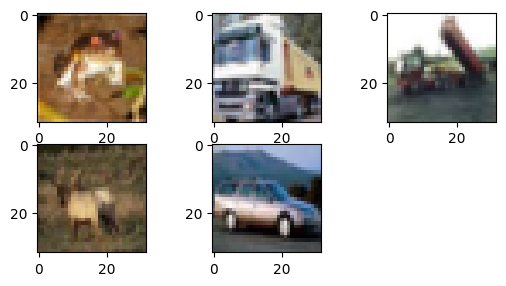

Images with Random Erasing:


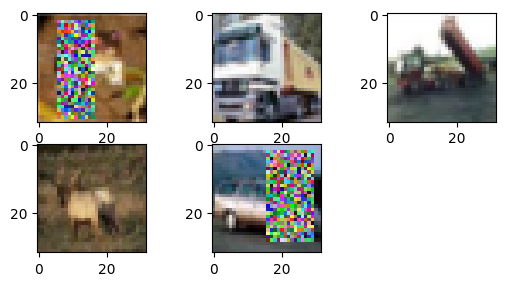

In [11]:
import matplotlib.pyplot as plt
print("Original images:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()
print("Images with Random Erasing:")
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train_random_erasing[i])
plt.show()

## Model

In [12]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         7

### Cutout Model Training

In [13]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',SparseTopKCategoricalAccuracy(k=3)])

#Train the model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_cutout, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_top3_accuracy = history.history['sparse_top_k_categorical_accuracy']


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 15s 7ms/step - loss: 1.6593 - accuracy: 0.3788 - sparse_top_k_categorical_accuracy: 0.7160 - val_loss: 1.2580 - val_accuracy: 0.5322 - val_sparse_top_k_categorical_accuracy: 0.8454
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1948 - accuracy: 0.5673 - sparse_top_k_categorical_accuracy: 0.8597 - val_loss: 0.9986 - val_accuracy: 0.6386 - val_sparse_top_k_categorical_accuracy: 0.8964
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9884 - accuracy: 0.6475 - sparse_top_k_categorical_accuracy: 0.8991 - val_loss: 0.9169 - val_accuracy: 0.6796 - val_sparse_top_k_categorical_accuracy: 0.9115
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8458 - accuracy: 0.7010 - sparse_top_k_categorical_accuracy: 0.9216 - val_loss: 0.8581 - val_accuracy: 0.7066 - val_sparse_top_k_categorical_accuracy: 0.9228
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/ste

313/313 - 1s - loss: 1.3953 - accuracy: 0.7372 - sparse_top_k_categorical_accuracy: 0.9295 - 668ms/epoch - 2ms/step

Test accuracy 0.7372000217437744

Top 3 accuracy 0.9294999837875366
313/313 [==============================] - 1s 2ms/step


<Figure size 1000x1000 with 0 Axes>

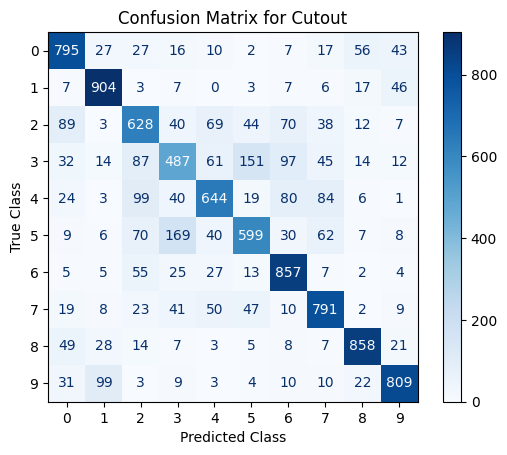

In [14]:
test_loss, test_acc, top3 = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy {}'.format(test_acc))
print('\nTop 3 accuracy {}'.format(top3))
# Prediction
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Cutout')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

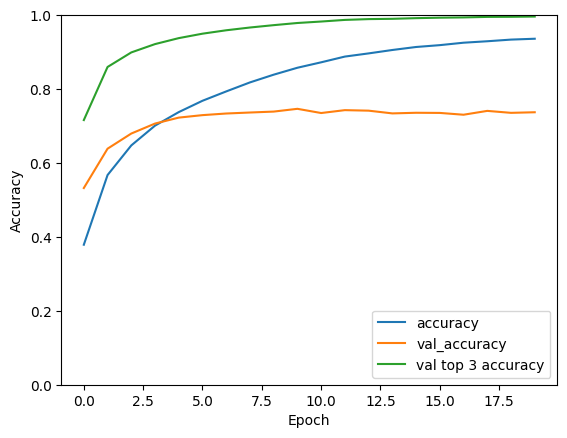

In [15]:
#Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(val_top3_accuracy, label = 'val top 3 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

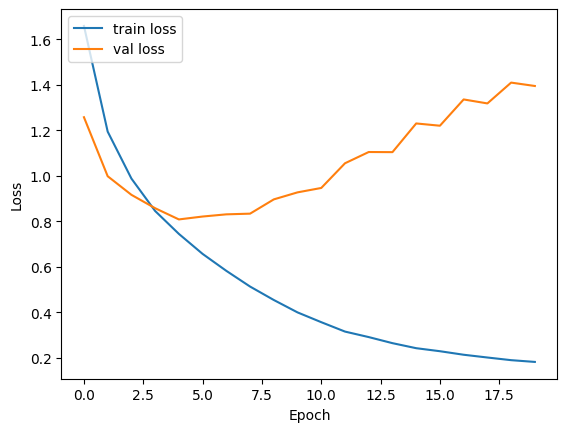

In [16]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper left')
#show plot
plt.show()

In [17]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn_cutout(14).h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights_cutout(14).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Random Erasing Training

In [18]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)        

In [19]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',SparseTopKCategoricalAccuracy(k=3)])

#Train the model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_random_erasing, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_top3_accuracy = history.history['sparse_top_k_categorical_accuracy']


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 11s 6ms/step - loss: 1.6458 - accuracy: 0.3874 - sparse_top_k_categorical_accuracy: 0.7180 - val_loss: 1.2743 - val_accuracy: 0.5316 - val_sparse_top_k_categorical_accuracy: 0.8431
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1767 - accuracy: 0.5742 - sparse_top_k_categorical_accuracy: 0.8613 - val_loss: 0.9930 - val_accuracy: 0.6446 - val_sparse_top_k_categorical_accuracy: 0.9030
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9760 - accuracy: 0.6495 - sparse_top_k_categorical_accuracy: 0.9010 - val_loss: 0.8645 - val_accuracy: 0.6907 - val_sparse_top_k_categorical_accuracy: 0.9216
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8378 - accuracy: 0.7022 - sparse_top_k_categorical_accuracy: 0.9243 - val_loss: 0.8677 - val_accuracy: 0.7012 - val_sparse_top_k_categorical_accuracy: 0.9204
Epoch 5/20
1563/1563 [==============================] - 9s 5ms/ste

313/313 - 1s - loss: 1.4227 - accuracy: 0.7343 - sparse_top_k_categorical_accuracy: 0.9205 - 661ms/epoch - 2ms/step

Test accuracy 0.7343000173568726

Top 3 accuracy 0.9204999804496765
313/313 [==============================] - 1s 2ms/step


<Figure size 1000x1000 with 0 Axes>

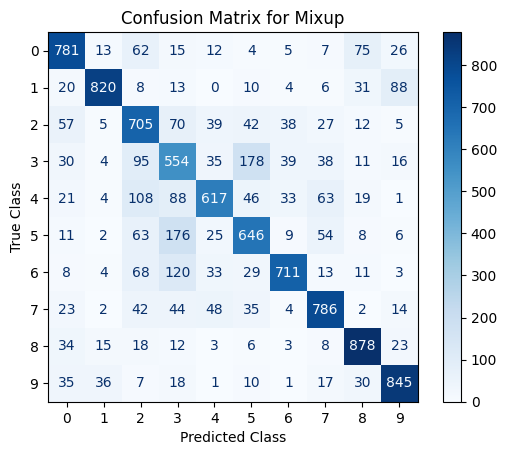

In [20]:
test_loss, test_acc, top3 = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy {}'.format(test_acc))
print('\nTop 3 accuracy {}'.format(top3))
# Prediction
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Mixup')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

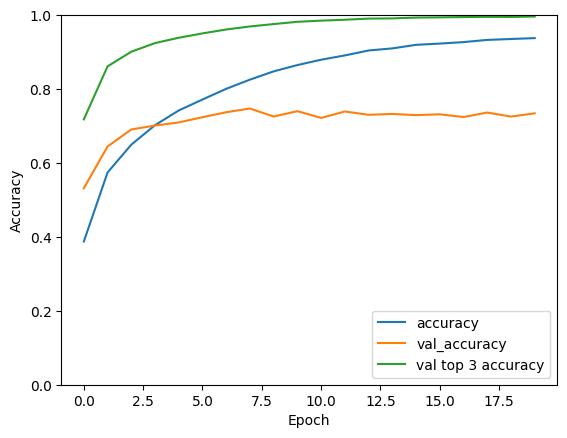

In [21]:
#Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(val_top3_accuracy, label = 'val top 3 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

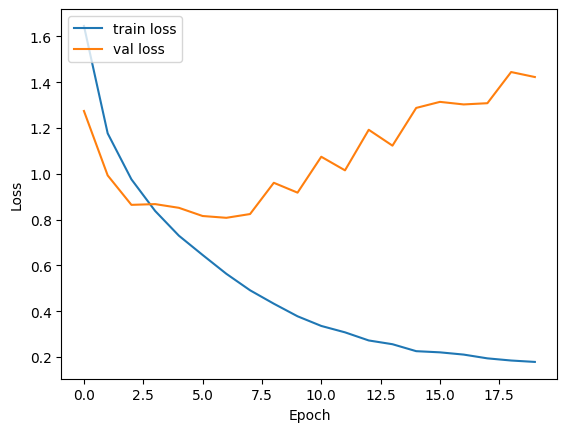

In [22]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper left')
#show plot
plt.show()

In [23]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn_random_erasing(0.4).h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights_random_erasing(0.4).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
